In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as sc_optim
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation()

In [3]:
def NM_logLjk(yj, sj, sigmak, derive = 0):
    '''
    this is one part of the posterior in normal means model. LogLjk is defined as:
    
    p(y | f, s2)   =   (1 / sqrt(2 * pi)) * sum_k [w_k * exp(logLjk)]            # derive = 0
    p'(y | f, s2)  = - (y / sqrt(2 * pi)) * sum_k [w_k * exp(logLjk)]            # derive = 1 (first derivative)
    p''(y | f, s2) = (y^2 / sqrt(2 * pi)) * sum_k [w_k * exp(logLjk)] + p' / y   # derive = 2 
    
    returns N x K matrix
    '''
    n = yj.shape[0]
    k = sigmak.shape[0]
    if not isinstance(sj, np.ndarray):
        sj = np.repeat(sj, n)
    # N x K length vector of posterior variances
    v2 = np.square(sj).reshape(n, 1) + np.square(sigmak).reshape(1, k)
    if derive == 0:
        logL = -0.5 * (np.log(v2) + np.square(yj.reshape(n, 1)) / v2)
    elif derive == 1:
        logL = -0.5 * (3 * np.log(v2) + (np.square(yj.reshape(n, 1)) / v2)) # N x K matrix
    elif derive == 2:
        logL = -0.5 * (5 * np.log(v2) + (np.square(yj.reshape(n, 1)) / v2)) # N x K matrix
    return logL

def NM_posterior(yj, sj, wk, sigmak):
    n = yj.shape[0]
    k = sigmak.shape[0]
    if not isinstance(sj, np.ndarray):
        sj = np.repeat(sj, n)
    # N x K length vector of posterior variances
    v2jk = np.square(sj).reshape(n, 1) + np.square(sigmak).reshape(1, k)
    u2jk = np.square(prior_grid).reshape(1, k) / v2jk
    mujk = y.reshape(n, 1) * u2jk
    varjk = np.square(sj).reshape(n, 1) * u2jk
    logLjk = -0.5 * (np.log(v2jk) + np.square(yj.reshape(n, 1)) / v2jk)
    phijk  = np.sqrt(0.5 / np.pi) * wk * np.exp(logLjk)
    phijk /= np.sum(phijk, axis = 1).reshape(n, 1)
    return phijk, mujk, varjk
    

def NM_marglik(y, s, w, sigma):
    '''
    y, s are vectors of length N
    w, sigma are vectors fo length K (w are prior mixture proportions)
    returns a vector of length N (marginal likelihoods under mixture prior)
    '''
    k = w.shape[0]
    L = np.exp(NM_logLjk(y, s, sigma)) # N x K
    #marglik = np.sqrt(0.5 / np.pi) * np.dot(w.reshape(1, k), L.T)
    marglik = np.sqrt(0.5 / np.pi) * np.dot(L, w)
    return marglik


def NM_marglik_deriv_over_y(y, s, w, sigma):
    '''
    returns NM_marglik_deriv(y) / y 
    ok even if y = 0
    '''
    k = w.shape[0]
    L = np.exp(NM_logLjk(y, s, sigma, derive = 1)) # N x K
    #deriv_over_y = - np.sqrt(0.5 / np.pi) * np.dot(w.reshape(1, k), L.T)
    deriv_over_y = - np.sqrt(0.5 / np.pi) * np.dot(L, w)
    return deriv_over_y


def NM_marglik_deriv(y, s, w, sigma):
    n = y.shape[0]
    deriv_over_y = NM_marglik_deriv_over_y(y, s, w, sigma)
    return  deriv_over_y * y.reshape(n,)


def NM_marglik_deriv2(y, s, w, sigma):
    k = w.shape[0]
    L = np.exp(NM_logLjk(y, s, sigma, derive = 2)) # N x K
    #deriv2 = np.sqrt(0.5 / np.pi) * np.dot(w.reshape(1, k), L.T) * np.square(y) \
    #            + NM_marglik_deriv_over_y(y, s, w, sigma)
    deriv2 = np.sqrt(0.5 / np.pi) * np.dot(L, w) * np.square(y) + NM_marglik_deriv_over_y(y, s, w, sigma)
    return deriv2

def lNM(y, s, w, prior_grid):
    return np.log(NM_marglik(y, s, w, prior_grid))

def lNM_deriv(y, s, w, prior_grid):
    fy    = NM_marglik(y, s, w, prior_grid)
    fy_d1 = NM_marglik_deriv(y, s, w, prior_grid)
    return fy_d1 / fy

def lNM_deriv2(y, s, w, prior_grid):
    fy    = NM_marglik(y, s, w, prior_grid)
    fy_d1 = NM_marglik_deriv(y, s, w, prior_grid)
    fy_d2 = NM_marglik_deriv2(y, s, w, prior_grid)
    l2 = ((fy * fy_d2) - (fy_d1 * fy_d1)) / (fy * fy)
    return l2

def lNM_wderiv(y, s, w, prior_grid):
    n = y.shape[0]
    mL = NM_marglik(y, s, w, prior_grid)
    mL_wderiv = np.sqrt(0.5 / np.pi) * np.exp(NM_logLjk(y, s, prior_grid))
    return mL_wderiv / mL.reshape(n, 1)

def lNM_deriv_wderiv(y, s, w, prior_grid):
    Ljk0 = np.sqrt(0.5 / np.pi) * np.exp(NM_logLjk(y, s, prior_grid))
    Ljk1 = - np.sqrt(0.5 / np.pi) * np.exp(NM_logLjk(y, s, prior_grid, derive = 1)) * y.reshape(n, 1)
    mL = NM_marglik(y, s, w, prior_grid).reshape(n, 1)
    mL_deriv = NM_marglik_deriv(y, s, w, prior_grid).reshape(n, 1)
    l2 = (Ljk1 / mL) - (Ljk0 * mL_deriv / np.square(mL))
    return l2

def NM_Sop(y, s, w, prior_grid):
    '''
    S_{f, sigma} operator for Normal Means (posterior mean operator)
    '''
    Sy = y + np.square(s) * lNM_deriv(y, s, w, prior_grid)
    return Sy

def NM_Sop_deriv(y, s, w, prior_grid):
    Sy_deriv = 1 + np.square(s) * lNM_deriv2(y, s, w, prior_grid)
    return Sy_deriv

def NM_Sop_wderiv(y, s, w, prior_grid):
    s2 = np.square(s)
    return s2 * lNM_deriv_wderiv(y, s, w, prior_grid)

def h_loss(y, s, w, prior_grid):
    s2 = np.square(s)
    ly = lNM(y, s, w, prior_grid)
    ly_deriv = lNM_deriv(y, s, w, prior_grid)
    h = - s2 * ly - 0.5 * s2 * s2 * np.square(ly_deriv)
    return h

def h_loss_deriv(y, s, w, prior_grid):
    s2 = np.square(s)
    ly = lNM(y, s, w, prior_grid)
    ly_deriv = lNM_deriv(y, s, w, prior_grid)
    ly_deriv2 = lNM_deriv2(y, s, w, prior_grid)
    h_deriv = -s2 * ly_deriv - s2 * s2 * ly_deriv * ly_deriv2
    return h_deriv

def h_loss_wderiv(y, s, w, prior_grid):
    n = y.shape[0]
    s2 = np.square(s)
    ly_deriv = lNM_deriv(y, s, w, prior_grid)
    ly_wderiv = lNM_wderiv(y, 1, w, prior_grid)
    ly_deriv_wderiv = lNM_deriv_wderiv(y, s, w, prior_grid)
    h_wderiv = - s2 * ly_wderiv - s2 * s2 * ly_deriv.reshape(n, 1) * ly_deriv_wderiv
    return h_wderiv

In [4]:
n = 100
k = 6
#y = np.random.normal(0, 1, size = n)
y = np.array([1.27028846, 0.22548772, 0.64593270, 1.99160286, 2.53478541, -1.10684041, -1.23304488, 1.84365424, -0.05939658, 0.28133048])
n = y.shape[0]
s = 1

# Prior
w = np.zeros(k)
w[1:(k-1)] = np.repeat(1/(k-1), (k - 2))
w[k-1] = 1 - np.sum(w)

prior_grid = np.arange(k)

In [5]:
idx = 2

eps = np.zeros(k)
eps[idx] += 1e-8

hsum_eps = np.sum(h_loss(y, s, w + eps, prior_grid))
hsum     = np.sum(h_loss(y, s, w, prior_grid))
numerical_wderiv = ( hsum_eps - hsum ) / eps[idx]
analytical_wderiv = np.sum(h_loss_wderiv(y, s, w, prior_grid), axis = 0)[idx]

print(f"Numerical: {numerical_wderiv}")
print(f"Analytical: {analytical_wderiv}")

Numerical: -12.003362570567333
Analytical: -12.003362385440276


In [9]:
np.sum(NM_Sop_wderiv(y, s, w, prior_grid), axis = 0)[idx]

-0.10300798542269571

In [12]:
idx = 1

eps = np.zeros(k)
eps[idx] += 1e-8

Sb_eps = NM_Sop(y, s, w + eps, prior_grid)
Sb     = NM_Sop(y, s, w, prior_grid)
numerical_wderiv = ( np.sum(Sb_eps) - np.sum(Sb) ) / eps[idx]
analytical_wderiv = np.sum(NM_Sop_wderiv(y, s, w, prior_grid), axis = 0)[idx]

print(f"Numerical: {numerical_wderiv}")
print(f"Analytical: {analytical_wderiv}")

Numerical: -1.9468151535306788
Analytical: -1.946815209859344


In [8]:
np.concatenate((y, w))

array([ 1.27028846,  0.22548772,  0.6459327 ,  1.99160286,  2.53478541,
       -1.10684041, -1.23304488,  1.84365424, -0.05939658,  0.28133048,
        0.        ,  0.2       ,  0.2       ,  0.2       ,  0.2       ,
        0.2       ])

In [9]:
np.sum(lNM_deriv_wderiv(y, s, w, prior_grid), axis = 0)

array([-2.90993115, -1.94681521, -0.10300799,  0.58874166,  0.73602665,
        0.72505488])

In [10]:
lNM_wderiv(y, s, w, prior_grid)

array([[1.42482049, 1.50814502, 1.21504363, 0.9313576 , 0.73844826,
        0.60700549],
       [2.57006138, 1.84055539, 1.1729814 , 0.83153437, 0.63842571,
        0.51650314],
       [2.24249719, 1.76001747, 1.18502365, 0.85560247, 0.66187833,
        0.53747807],
       [0.56403417, 1.07509224, 1.23273267, 1.0628818 , 0.88455785,
        0.74473545],
       [0.20526347, 0.72343091, 1.1994642 , 1.16947885, 1.02380526,
        0.88382078],
       [1.65319853, 1.58789978, 1.20687121, 0.90729506, 0.71363822,
        0.58429573],
       [1.47674175, 1.52709078, 1.21322131, 0.92563569, 0.73250411,
        0.60154812],
       [0.70807171, 1.17114482, 1.23330249, 1.03362804, 0.85022141,
        0.71170324],
       [2.61548171, 1.85105674, 1.17133077, 0.82840205, 0.63540152,
        0.51380891],
       [2.54324659, 1.83428465, 1.17395833, 0.83340545, 0.64023521,
        0.51811635]])

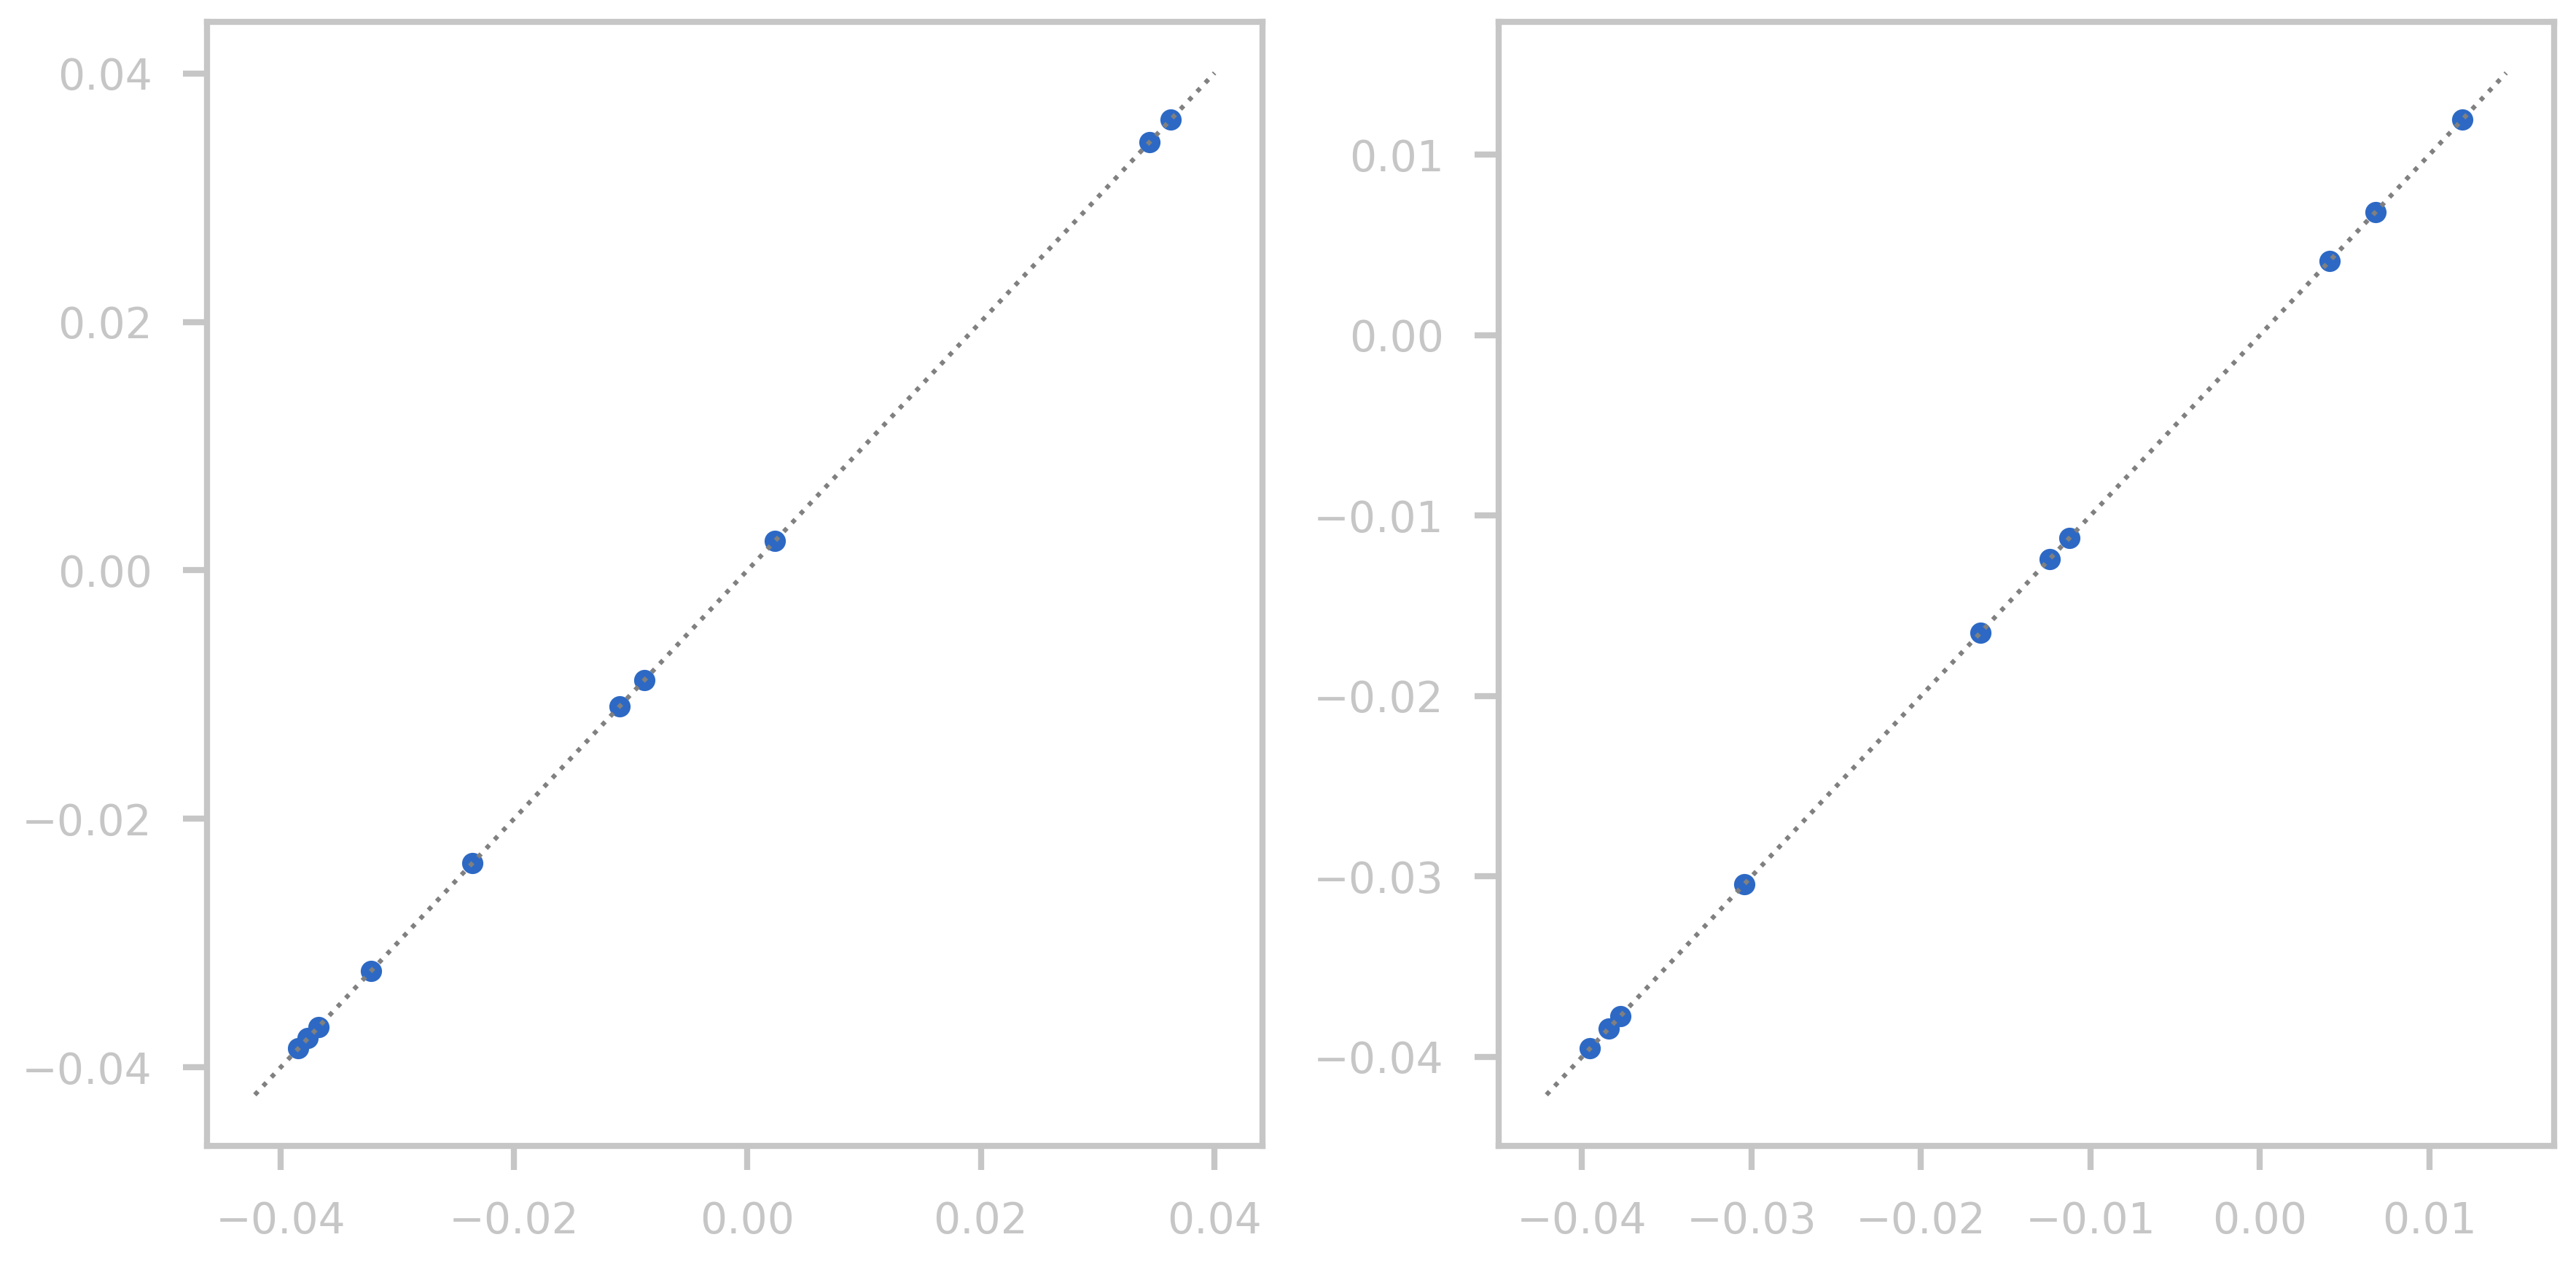

In [11]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

s = 1
eps = 1e-8
deriv_analytic = (NM_marglik(y + eps, s, w, prior_grid) - NM_marglik(y, s, w, prior_grid)) / eps
deriv_numeric  = NM_marglik_deriv(y, s, w, prior_grid)

deriv2_analytic = (NM_marglik_deriv(y + eps, s, w, prior_grid) - NM_marglik_deriv(y, s, w, prior_grid)) / eps
deriv2_numeric  = NM_marglik_deriv2(y, s, w, prior_grid)

ax1.scatter(deriv_numeric, deriv_analytic)
ax2.scatter(deriv2_numeric, deriv2_analytic)
mpl_utils.plot_diag(ax1)
mpl_utils.plot_diag(ax2)
plt.tight_layout()
plt.show()

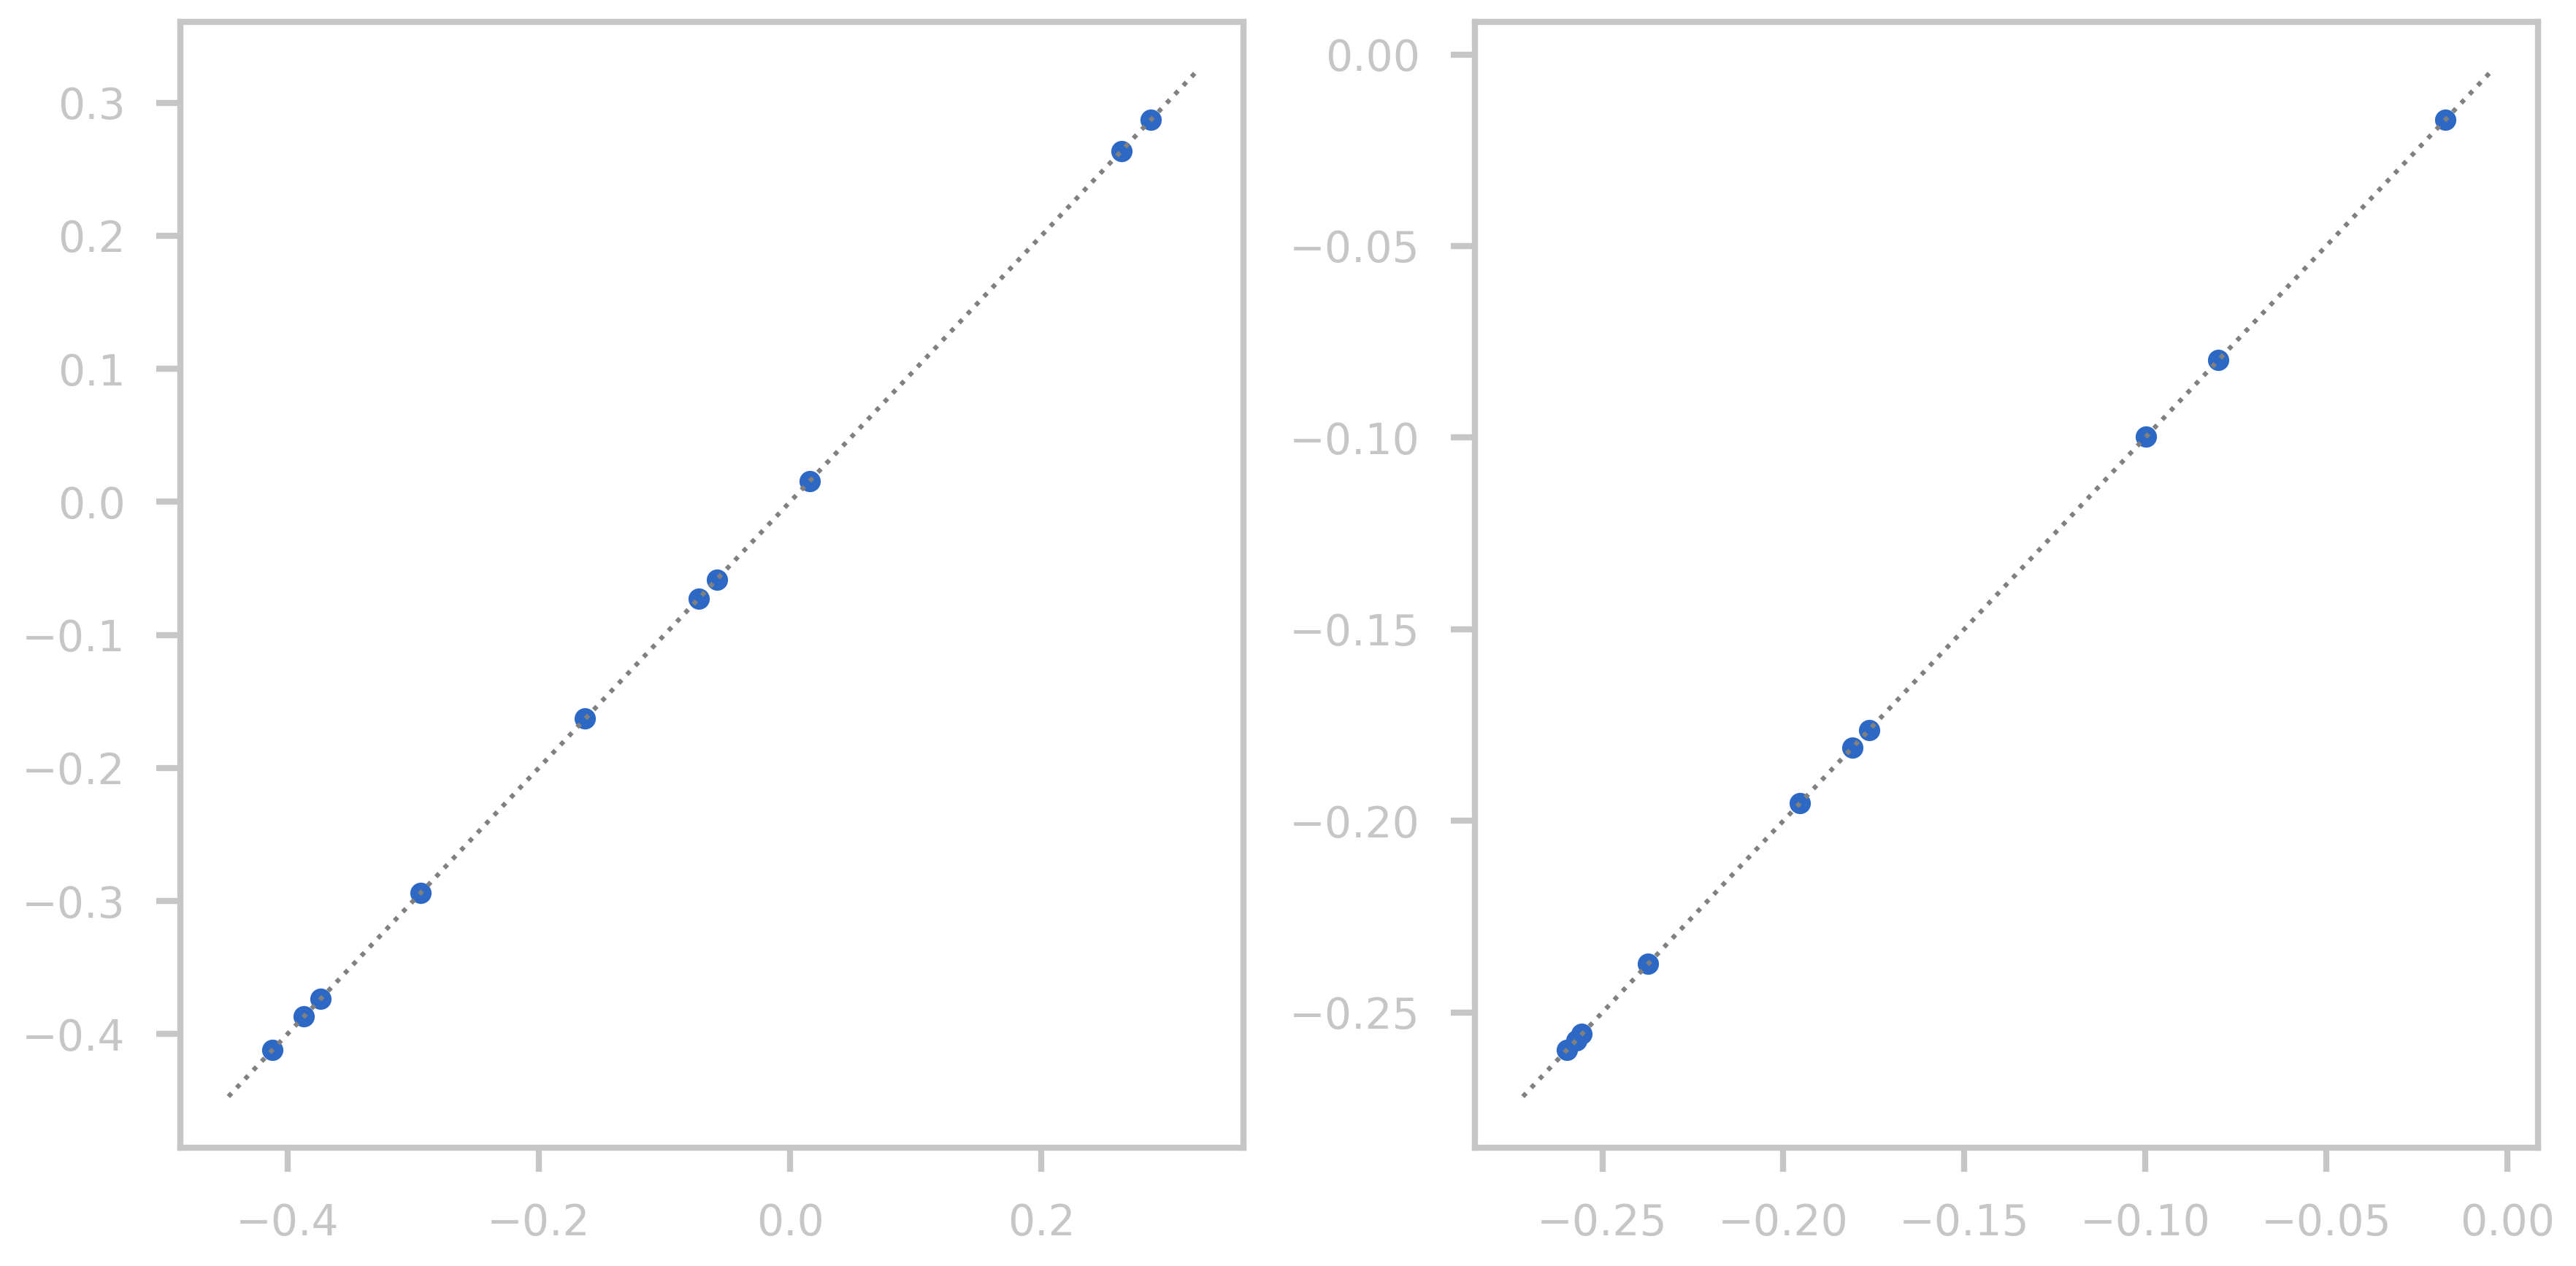

In [12]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

s = 1
eps = 1e-8
deriv_analytic = (lNM(y + eps, s, w, prior_grid) - lNM(y, s, w, prior_grid)) / eps
deriv_numeric  = lNM_deriv(y, s, w, prior_grid)

deriv2_analytic = (lNM_deriv(y + eps, s, w, prior_grid) - lNM_deriv(y, s, w, prior_grid)) / eps
deriv2_numeric  = lNM_deriv2(y, s, w, prior_grid)

ax1.scatter(deriv_numeric, deriv_analytic)
ax2.scatter(deriv2_numeric, deriv2_analytic)
mpl_utils.plot_diag(ax1)
mpl_utils.plot_diag(ax2)
plt.tight_layout()
plt.show()

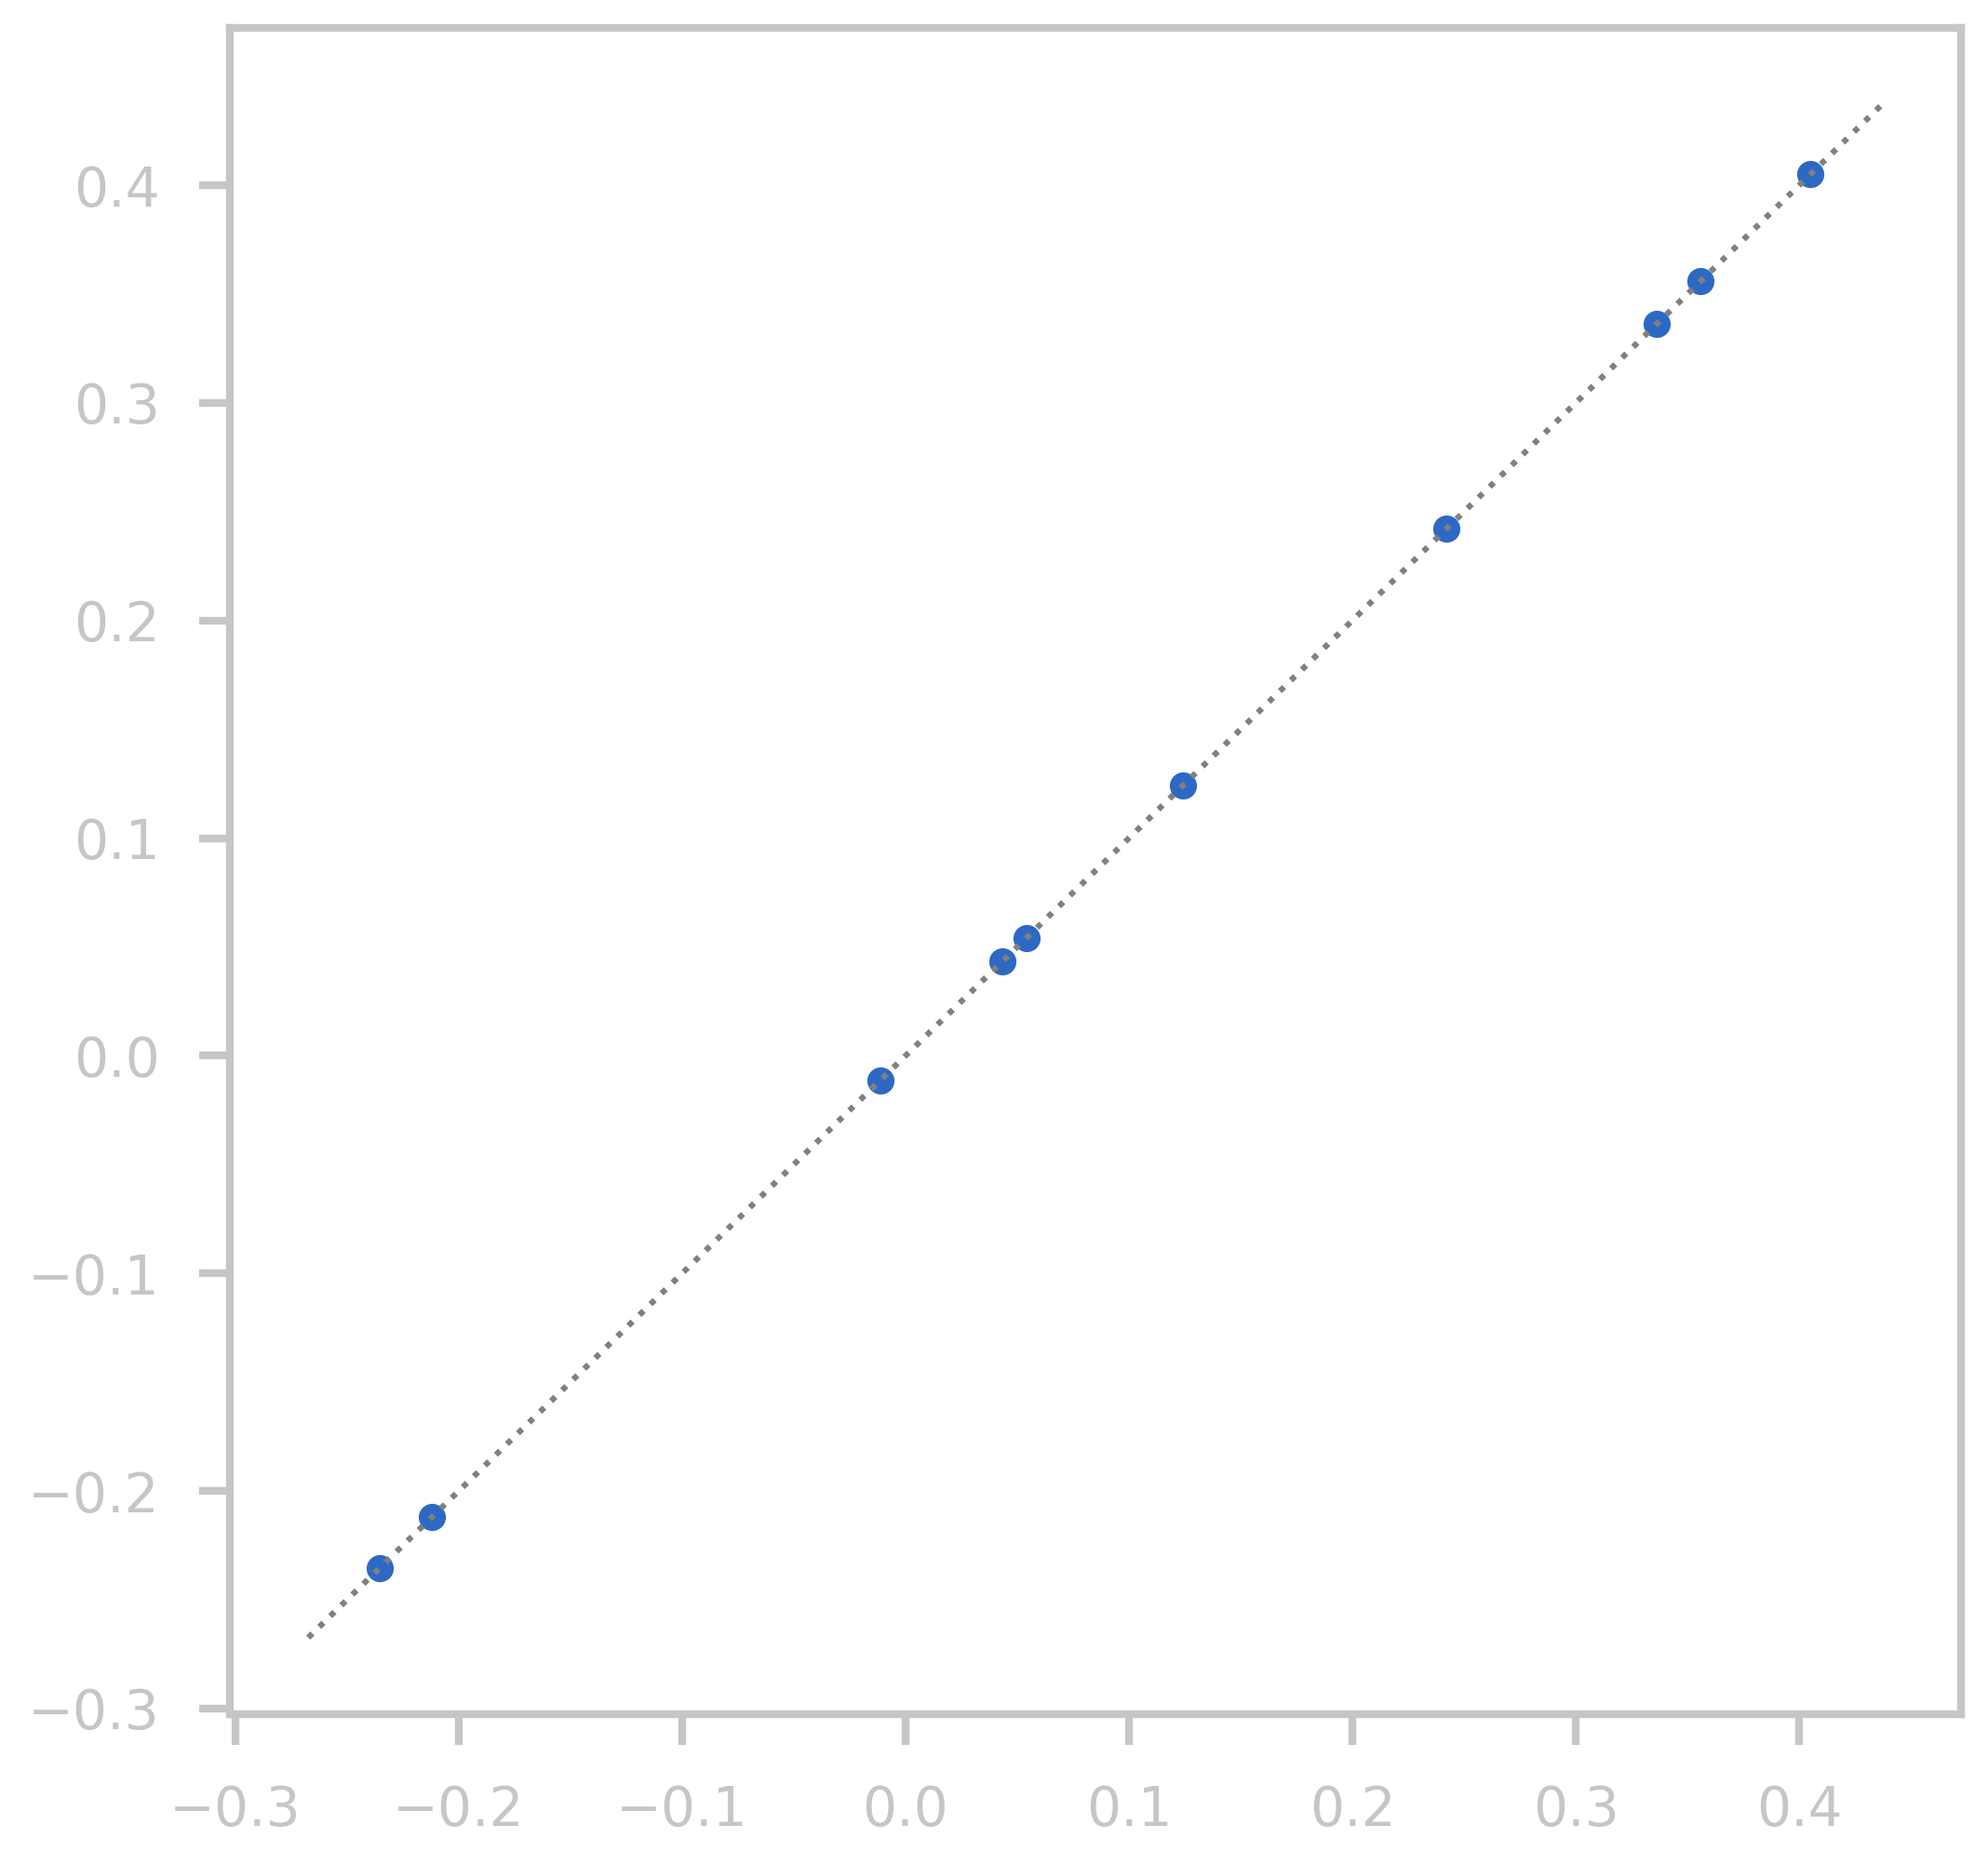

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

s = 1
eps = 1e-8
deriv_analytic = (h_loss(y + eps, s, w, prior_grid) - h_loss(y, s, w, prior_grid)) / eps
deriv_numeric  = h_loss_deriv(y, s, w, prior_grid)

ax1.scatter(deriv_numeric, deriv_analytic)
mpl_utils.plot_diag(ax1)
plt.show()

In [14]:
w

array([0. , 0.2, 0.2, 0.2, 0.2, 0.2])

In [15]:
prior_grid

array([0, 1, 2, 3, 4, 5])

In [16]:
hobj = np.sum(h_loss(y, s, w, prior_grid))

In [17]:
w

array([0. , 0.2, 0.2, 0.2, 0.2, 0.2])

In [18]:
phijk, mujk, varjk = NM_posterior(y, s, w, prior_grid)
np.sum(phijk * mujk, axis = 1)

array([ 0.97634333,  0.16706623,  0.48287604,  1.60481075,  2.12274432,
       -0.84330054, -0.94575081,  1.47013655, -0.04395616,  0.20858613])

In [19]:
np.sum(phijk, axis = 0) / n

array([0.        , 0.29757436, 0.24007859, 0.18758443, 0.15038232,
       0.12438031])

In [20]:
X = np.random.normal(0, 1, size = n * p).reshape(n, p)

NameError: name 'p' is not defined

In [ ]:
np.sum(X[:, 0] * X[:, 0])

In [ ]:
np.sum(np.square(X), axis = 0)

In [ ]:
def plr_objective(b, X, y, residual_var, w, prior_grid):
    d = np.sum(np.square(X), axis = 0)
    s = np.sqrt(residual_var / d)
    Sb = NM_Sop(b, s, w, prior_grid)
    r = y - np.dot(X, Sb)
    obj = (0.5 * np.sum(np.square(r)) / residual_var) + (np.sum(h_loss(b, s, w, prior_grid)) / residual_var)
    grad = - (np.dot(r.T, X) * NM_Sop_deriv(b, s, w, prior_grid) / residual_var) \
            + (h_loss_deriv(b, s, w, prior_grid) / residual_var)
    return obj, grad

In [ ]:
plr_objective(b_init, *args)

In [ ]:

#plr_min = sc_optim.minimize(plr_objective, b_init, args = args, method = method, jac=True, options = mopts[method])

In [ ]:
n = 100
p = 2000
k = 6
residual_var = 1
X = np.random.normal(0, 1, size = n * p).reshape(n, p)
Xnorm = X / np.sqrt(np.sum(np.square(X), axis = 0))
b = np.random.normal(0, 1, size = p)
y = np.dot(Xnorm, b) + np.random.normal(0, residual_var, size = n)

## Prior
w = np.zeros(k)
w[1:(k-1)] = np.repeat(1/(k-1), (k - 2))
prior_grid = np.arange(k)

In [ ]:
1 - np.sum(w)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(Xnorm, b), y)
plt.show()

In [ ]:
eps = np.zeros(p)
idx = 5
eps[idx] += 1e-5

f_plr0 = plr_objective(b, X, y, residual_var, w, prior_grid)
f_plr1 = plr_objective(b + eps, X, y, residual_var, w, prior_grid)

analytical_grad = f_plr0[1][idx]
numerical_grad = (f_plr1[0] - f_plr0[0]) / eps[idx]
print("Analytical grad: ", analytical_grad)
print("Numerical grad: ", numerical_grad)

In [ ]:
args = X, y, residual_var, w, prior_grid
method = 'L-BFGS-B'
mopts = dict()
# sc_optim.show_options(solver = 'minimize', method = 'l-bfgs-b')
mopts['L-BFGS-B'] = {'maxiter': 200000, # Maximum number of iterations
                     'maxfun': 2000000, # Maximum number of function evaluations
                     'ftol': 1e-9, # Function tolerance.
                                   # stop when ``(f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol``.
                     'gtol': 1e-9, # Gradient tolerance
                                   # stop when ``max{|proj g_i | i = 1, ..., n} <= gtol``
                     'disp': True
                     }

In [ ]:
b0 = np.zeros(p)
bwarm = b.copy()

plr_min_0 = sc_optim.minimize(plr_objective, b0, args = args, method = method, 
                              jac=True, options = mopts[method])
plr_min_w = sc_optim.minimize(plr_objective, bwarm, args = args, method = method, 
                              jac=True, options = mopts[method])


In [ ]:
plr_min_0.keys()

In [ ]:
plr_min_0.njev

In [ ]:
ypred = np.dot(X, plr_min_w.x)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y, ypred)
plt.show()